In [1]:
from glob import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from openslide import open_slide 

In [2]:
# plt.rcParams['image.cmap']

# #plt.rcParams['image.cmap'] = 'Greys'
# plt.rcParams['image.cmap'] = 'viridis'

In [3]:
SOURCE_IMG_DIR = '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/source_data/'

In [4]:
all_img_paths = glob(SOURCE_IMG_DIR + '*.tif')

In [5]:
all_img_filenames = [os.path.basename(x) for x in all_img_paths]

In [6]:
all_img_ids = np.unique([x.split('.')[0].split('_')[1] for x in all_img_filenames])

In [7]:
len(all_img_ids)

22

In [8]:
img_ids_to_ignore = []

for img_id in all_img_ids:
    slide_img_filename = 'tumor_{}.tif'.format(img_id)
    mask_img_filename = 'tumor_{}_mask.tif'.format(img_id)
    
    if (slide_img_filename not in all_img_filenames) or\
        (mask_img_filename not in all_img_filenames):
        img_ids_to_ignore.append(img_id)

In [9]:
img_ids_to_ignore

['038']

In [10]:
all_img_ids = np.setdiff1d(all_img_ids, img_ids_to_ignore)

In [11]:
all_img_ids

array(['001', '002', '005', '012', '016', '019', '023', '031', '035',
       '057', '059', '064', '075', '078', '081', '084', '091', '094',
       '096', '101', '110'], dtype='<U3')

In [12]:
# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [13]:
meta_infos = []

for img_id in all_img_ids:
    slide_img_filename = 'tumor_{}.tif'.format(img_id)
    mask_img_filename = 'tumor_{}_mask.tif'.format(img_id)
    
    slide = open_slide(os.path.join(SOURCE_IMG_DIR, slide_img_filename))
    mask = open_slide(os.path.join(SOURCE_IMG_DIR, mask_img_filename))
    
    level_dimensions = slide.level_dimensions
    level_downsamples = slide.level_downsamples
    
    level_5_size = level_dimensions[5][0] * level_dimensions[5][1]
    level_5_mask_img = read_slide(mask, 
                                  x=0,
                                  y=0,
                                  level=5,
                                  width=slide.level_dimensions[5][0],
                                  height=slide.level_dimensions[5][1])
    level_5_mask_img = level_5_mask_img[:, :, 0]
    level_5_mask_size = level_5_mask_img.sum()    
    
    # In some cases slide level dimensions is more
    # Sanity check 1
    for i, dims in enumerate(mask.level_dimensions):
        assert slide.level_dimensions[i] == dims
        
    # Sanity check 2
    for i, dims in enumerate(slide.level_dimensions):
        assert (slide.level_downsamples[i] * np.array(dims)
                == np.array(slide.level_dimensions[0])).all()
    
    for i, dims in enumerate(mask.level_dimensions):
        assert (mask.level_downsamples[i] * np.array(dims)
                == np.array(mask.level_dimensions[0])).all()
        
    # Sanity check 3
    assert (slide.level_count - mask.level_count) in [0, 1]
    
    
    meta_info = {
        'img_id': img_id,
        'slide_img_filename': slide_img_filename,
        'mask_img_filename': mask_img_filename,
        'level_dimensions': level_dimensions,
        'level_downsamples': level_downsamples,
        'level_5_img_size': level_5_size,
        'level_5_mask_area': level_5_mask_size,
        'mask_proportion': (level_5_mask_size / level_5_size) * 100
    }
    
    meta_infos.append(meta_info)

In [14]:
meta_info_df = pd.DataFrame(meta_infos)

In [16]:
meta_info_df.head()

,img_id,level_5_img_size,level_5_mask_area,level_dimensions,level_downsamples,mask_img_filename,mask_proportion,slide_img_filename
0,001,21123072,11116,"((97792, 221184), (48896, 110592), (24448, 552...","(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ...",tumor_001_mask.tif,0.052625,tumor_001.tif
1,002,20976384,938,"((97792, 219648), (48896, 109824), (24448, 549...","(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ...",tumor_002_mask.tif,0.004472,tumor_002.tif
2,005,20976384,2323,"((97792, 219648), (48896, 109824), (24448, 549...","(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ...",tumor_005_mask.tif,0.011074,tumor_005.tif
3,012,20585216,1115,"((97792, 215552), (48896, 107776), (24448, 538...","(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ...",tumor_012_mask.tif,0.005417,tumor_012.tif
4,016,21123072,156981,"((97792, 221184), (48896, 110592), (24448, 552...","(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ...",tumor_016_mask.tif,0.743173,tumor_016.tif


In [35]:
meta_info_df.to_pickle('../test/tumor_img_meta_info.pkl')

In [31]:
binwidth = 0.2

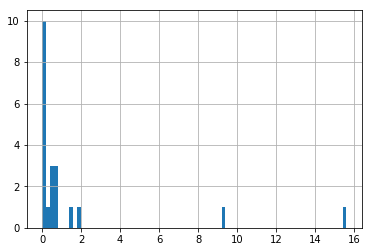

In [33]:
mask_proportions = meta_info_df['mask_proportion']
mask_proportions.hist(bins=np.arange(mask_proportions.min(), 
                                     mask_proportions.max() + binwidth,
                                     binwidth))

In [17]:
meta_info_df['level_downsamples'].value_counts()

(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0)    13
(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0)            7
(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0)                   1
Name: level_downsamples, dtype: int64

In [20]:
orig_img_sizes = meta_info_df['level_dimensions'].str[5].values

In [21]:
img_heights = [x[0] for x in orig_img_sizes]
img_widths = [x[1] for x in orig_img_sizes]

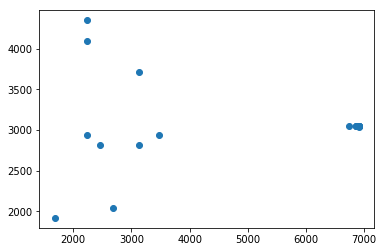

In [22]:
plt.scatter(img_widths, img_heights)

In [34]:
# my rationale for using Zoom = 5 / img_window = 256 *256

In [ ]:
256 * 256

In [ ]:
ZOOM_LEVEL = 5

In [ ]:
DEST_FILE_DIR = '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/slide_and_mask_comparison'

In [ ]:
def plot_slide_and_mask_images(slide_image,
                               mask_image,
                               image_id):
    title = 'Image_{}'.format(image_id)
    filename = 'image_{}_slide_and_mask_200dpi.png'.format(image_id)
    
    fig, axes = plt.subplots(1, 3, figsize=(30, 30), dpi=200)
    axes[0].imshow(slide_image,)#, aspect='auto')
    
    axes[1].imshow(slide_image)
    axes[1].imshow(mask_image, alpha=0.5)
    
    axes[2].imshow(mask_image,)# aspect='auto')
    
    fig.suptitle(title, fontsize=30)
    fig.subplots_adjust(top=0.88)
    #fig.tight_layout()
    fig.tight_layout()
    plt.savefig(os.path.join(DEST_FILE_DIR, filename))
    plt.close()
    #plt.show()

In [ ]:
for img_id in all_img_ids:
    slide_img_filename = 'tumor_{}.tif'.format(img_id)
    mask_img_filename = 'tumor_{}_mask.tif'.format(img_id)
    
    slide = open_slide(os.path.join(SOURCE_IMG_DIR, slide_img_filename))
    mask = open_slide(os.path.join(SOURCE_IMG_DIR, mask_img_filename))
    
    slide_image = read_slide(slide, 
                             x=0, 
                             y=0, 
                             level=ZOOM_LEVEL, 
                             width=slide.level_dimensions[ZOOM_LEVEL][0], 
                             height=slide.level_dimensions[ZOOM_LEVEL][1])
    mask_image = read_slide(mask, 
                             x=0, 
                             y=0, 
                             level=ZOOM_LEVEL, 
                             width=slide.level_dimensions[ZOOM_LEVEL][0], 
                             height=slide.level_dimensions[ZOOM_LEVEL][1])
    mask_image = mask_image[:, :, 0]
    
    plot_slide_and_mask_images(slide_image,
                               mask_image,
                               img_id)